In [2]:
import numpy as np
import pandas as pd
import datetime
import torch
import pytorch_lightning as pl
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from scipy.interpolate import make_interp_spline, BSpline

import os
print(os.listdir("./datasets"))

C:\ProgramData\Anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Unsupported `ReduceOp` for distributed computing.
  warnings.warn(*args, **kwargs)


['AUDUSD-2000-2020-15m.csv', 'EURCHF-2000-2020-15m.csv', 'EURJPY-2000-2020-15m.csv', 'EURUSD-2000-2020-15m.csv', 'EUR_USD Historical Data.csv', 'USDCAD-2000-2020-15m.csv', 'USDCHF-2000-2020-15m.csv', 'USDJPY-2000-2020-15m.csv']


In [5]:
df = pd.read_csv('./datasets/EURUSD-2000-2020-15m.csv',parse_dates=['DATE_TIME'])
df[:,:3]

TypeError: '(slice(None, None, None), slice(None, 3, None))' is an invalid key

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500751 entries, 0 to 500750
Data columns (total 5 columns):
DATE_TIME    500751 non-null datetime64[ns]
HIGH         500751 non-null float64
LOW          500751 non-null float64
OPEN         500751 non-null float64
CLOSE        500751 non-null float64
dtypes: datetime64[ns](1), float64(4)
memory usage: 19.1 MB


In [41]:
df1 = pd.read_csv('EURJPY-2000-2020-15m.csv',parse_dates=['DATE_TIME'])
df2 = pd.read_csv('USDJPY-2000-2020-15m.csv',parse_dates=['DATE_TIME'])
df1

,DATE_TIME,HIGH,LOW,OPEN,CLOSE
0,2000-01-03 00:00:00,102.960,102.780,102.890,102.950
1,2000-01-03 00:15:00,103.130,102.920,102.960,103.130
2,2000-01-03 00:30:00,103.050,102.960,103.030,102.960
3,2000-01-03 00:45:00,103.130,103.020,103.050,103.070
4,2000-01-03 01:00:00,103.550,103.380,103.460,103.380
...,...,...,...,...,...
487972,2020-03-20 21:45:00,118.698,118.434,118.563,118.455
487973,2020-03-20 22:00:00,118.845,118.453,118.458,118.815
487974,2020-03-20 22:15:00,118.853,118.662,118.814,118.696
487975,2020-03-20 22:30:00,118.818,118.630,118.692,118.797


In [33]:
dfake = pd.read_csv('EUR_USD Historical Data.csv',parse_dates=True)
dfake.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 6 columns):
Date        5000 non-null object
Price       5000 non-null float64
Open        5000 non-null float64
High        5000 non-null float64
Low         5000 non-null float64
Change %    5000 non-null object
dtypes: float64(4), object(2)
memory usage: 234.5+ KB


In [51]:
pd.to_numeric(df['DATE_TIME'])

0          946857600000000000
1          946858500000000000
2          946859400000000000
3          946860300000000000
4          946861200000000000
                 ...         
500746    1584594000000000000
500747    1584594900000000000
500748    1584595800000000000
500749    1584596700000000000
500750    1584597600000000000
Name: DATE_TIME, Length: 500751, dtype: int64

In [25]:
df2

,DATE_TIME,HIGH,LOW,OPEN,CLOSE
0,2000.01.03 00:00:00,102.150,102.120,102.140,102.140
1,2000.01.03 00:15:00,102.260,102.130,102.150,102.260
2,2000.01.03 00:30:00,102.170,102.140,102.150,102.150
3,2000.01.03 00:45:00,102.200,102.120,102.160,102.200
4,2000.01.03 01:00:00,102.220,102.120,102.200,102.120
...,...,...,...,...,...
500229,2020.03.19 05:30:00,109.391,109.178,109.232,109.226
500230,2020.03.19 05:45:00,109.340,109.210,109.225,109.285
500231,2020.03.19 06:00:00,109.446,109.273,109.284,109.439
500232,2020.03.19 06:15:00,109.553,109.400,109.439,109.401


In [26]:
low = (df["LOW"] - df["LOW"].min()) / (df["LOW"].max() - df["LOW"].min())
low1 = (df1["LOW"] - df1["LOW"].min()) / (df1["LOW"].max() - df1["LOW"].min())
low2 = (df2["LOW"] - df2["LOW"].min()) / (df2["LOW"].max() - df2["LOW"].min())

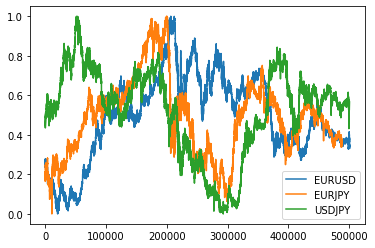

In [40]:
plt.figure(figsize = (15,30))
plt.plot(low,label = 'EURUSD')
plt.plot(low1, label = 'EURJPY')
plt.plot(low2, label = 'USDJPY')
plt.legend()




In [9]:
torch.cuda.is_available()

True

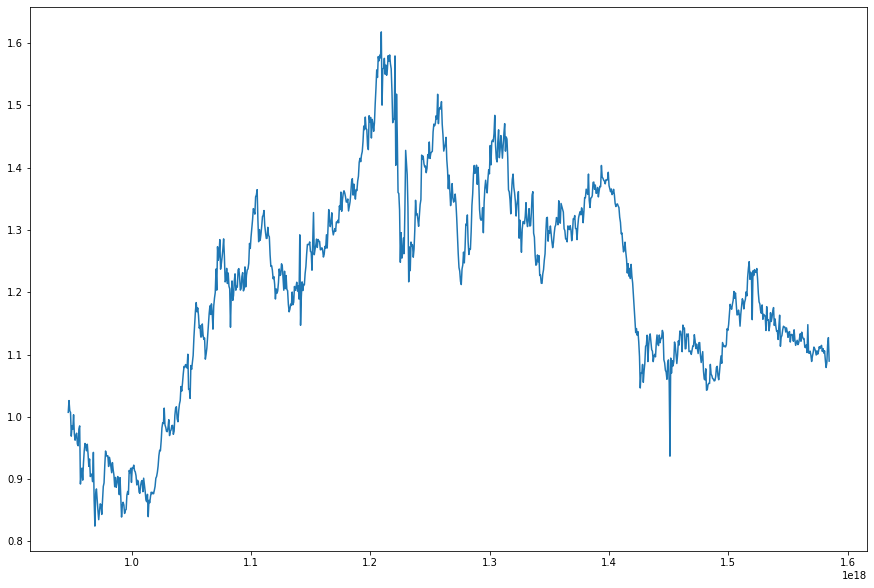

In [56]:
low = df['LOW']
date = pd.to_numeric(df['DATE_TIME'])


xnew = np.linspace(date.min(), date.max(), 1000) 
spl = make_interp_spline(date, low, k=3)  # type: BSpline
low_smooth = spl(xnew)

plt.figure(figsize = (15,10))
plt.plot(xnew, low_smooth, label = 'EURUSD')

In [58]:
def split_sequence(source,
                   target,
                   source_len,
                   target_len,
                   step,
                   target_start_next):
    """ Split sequence with sliding window into
        sequences of context features and target.
        Args:
            source (np.array): Source sequence
            target (np.array): Target sequence
            source_len (int): Length of input sequence.
            target_len (int): Length of target sequence.
            target_start_next (bool): If True, target sequence
                    starts on the next time step of last step of source
                    sequence. If False, target sequence starts at the
                    same time step of source sequence.
        Return:
            X (np.array): sequence of features
            y (np.array): sequence of targets
    """
    assert len(source) == len(target), \
            'Source sequence and target sequence should have the same length.'

    X, y = list(), list()
    if not target_start_next:
        target = np.vstack((np.zeros(target.shape[1], dtype=target.dtype), target))
    for i in range(0, len(source), step):
        # Find the end of this pattern:
        src_end = i + source_len
        tgt_end = src_end + target_len
        # Check if beyond the length of sequence:
        if tgt_end > len(target):
            break
        # Split sequences:
        X.append(source[i:src_end, :])
        y.append(target[src_end:tgt_end, :])
    return np.array(X), np.array(y)

In [64]:
nice = df.iloc[:,1:].to_numpy()

source,target = split_sequence(nice,nice,192,4,192//3,True) # 192 is 2 days

source


array([[[1.008  , 1.0073 , 1.0073 , 1.0077 ],
        [1.0087 , 1.0076 , 1.0078 , 1.0086 ],
        [1.0089 , 1.0079 , 1.0087 , 1.0079 ],
        ...,
        [1.0294 , 1.0288 , 1.0291 , 1.0292 ],
        [1.0297 , 1.0291 , 1.0293 , 1.0296 ],
        [1.0297 , 1.0289 , 1.0297 , 1.0293 ]],

       [[1.0085 , 1.007  , 1.0077 , 1.0078 ],
        [1.0085 , 1.0073 , 1.0081 , 1.0075 ],
        [1.0098 , 1.0072 , 1.0074 , 1.0094 ],
        ...,
        [1.0371 , 1.0338 , 1.0352 , 1.0371 ],
        [1.0379 , 1.0361 , 1.0369 , 1.0365 ],
        [1.0366 , 1.0331 , 1.0361 , 1.0339 ]],

       [[1.0234 , 1.0222 , 1.0227 , 1.0223 ],
        [1.0231 , 1.0213 , 1.0225 , 1.022  ],
        [1.0248 , 1.0217 , 1.0218 , 1.0241 ],
        ...,
        [1.0372 , 1.0363 , 1.0368 , 1.0364 ],
        [1.0368 , 1.0347 , 1.0368 , 1.0348 ],
        [1.0356 , 1.0337 , 1.0351 , 1.0341 ]],

       ...,

       [[1.11196, 1.10932, 1.11185, 1.10941],
        [1.11119, 1.1066 , 1.10943, 1.10695],
        [1.10871, 1.10

In [66]:
source.shape

(7822, 192, 4)

In [68]:
target.shape

(7822, 4, 4)

In [10]:
df[1:3]

NameError: name 'df' is not defined